In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL # image module in python
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### reading dataset and process it

In [2]:
train_data_dir = ".//dataset//train"
test_data_dir = ".//dataset//test"
type(train_data_dir)

str

In [3]:
import pathlib
train_data_dir = pathlib.Path(train_data_dir)
test_data_dir = pathlib.Path(test_data_dir)
train_data_dir

WindowsPath('dataset/train')

In [4]:
list(train_data_dir.glob('*/*.jpg')) # it will go through all subdirectories and find all jpg files

[WindowsPath('dataset/train/angry/Training_10118481.jpg'),
 WindowsPath('dataset/train/angry/Training_10120469.jpg'),
 WindowsPath('dataset/train/angry/Training_10131352.jpg'),
 WindowsPath('dataset/train/angry/Training_10161559.jpg'),
 WindowsPath('dataset/train/angry/Training_1021836.jpg'),
 WindowsPath('dataset/train/angry/Training_10269675.jpg'),
 WindowsPath('dataset/train/angry/Training_10278738.jpg'),
 WindowsPath('dataset/train/angry/Training_10290703.jpg'),
 WindowsPath('dataset/train/angry/Training_10295477.jpg'),
 WindowsPath('dataset/train/angry/Training_10315441.jpg'),
 WindowsPath('dataset/train/angry/Training_10316849.jpg'),
 WindowsPath('dataset/train/angry/Training_10333072.jpg'),
 WindowsPath('dataset/train/angry/Training_10334355.jpg'),
 WindowsPath('dataset/train/angry/Training_10345473.jpg'),
 WindowsPath('dataset/train/angry/Training_10422050.jpg'),
 WindowsPath('dataset/train/angry/Training_10485618.jpg'),
 WindowsPath('dataset/train/angry/Training_10503476.jpg')

In [5]:
image_count = len(list(train_data_dir.glob('*/*.jpg')))
image_count

28709

In [6]:
angry = list(train_data_dir.glob('angry/*')) # get all angry file path
angry[:5]

[WindowsPath('dataset/train/angry/Training_10118481.jpg'),
 WindowsPath('dataset/train/angry/Training_10120469.jpg'),
 WindowsPath('dataset/train/angry/Training_10131352.jpg'),
 WindowsPath('dataset/train/angry/Training_10161559.jpg'),
 WindowsPath('dataset/train/angry/Training_1021836.jpg')]

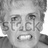

In [7]:
PIL.Image.open(str(angry[8])) # it will show the first angry image

### transfer image files into numpy array

and resize them all into 48*48

In [8]:
train_face_images_dict = {
    'angry': list(train_data_dir.glob('angry/*')),
    'disgust': list(train_data_dir.glob('disgust/*')),
    'fear': list(train_data_dir.glob('fear/*')),
    'happy': list(train_data_dir.glob('happy/*')),
    'neutral': list(train_data_dir.glob('neutral/*')),
    'sad': list(train_data_dir.glob('sad/*')),
    'surprise': list(train_data_dir.glob('surprise/*'))
}

In [9]:
test_face_images_dict = {
    'angry': list(test_data_dir.glob('angry/*')),
    'disgust': list(test_data_dir.glob('disgust/*')),
    'fear': list(test_data_dir.glob('fear/*')),
    'happy': list(test_data_dir.glob('happy/*')),
    'neutral': list(test_data_dir.glob('neutral/*')),
    'sad': list(test_data_dir.glob('sad/*')),
    'surprise': list(test_data_dir.glob('surprise/*'))
}

In [10]:
faces_expression_dict = {
    'angry': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'neutral': 4,
    'sad': 5,
    'surprise': 6
}

#### converting images into arrays

In [11]:
x_train, y_train = [], []

for express_name, images in train_face_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(48,48))
        x_train.append(resized_img)
        y_train.append(faces_expression_dict[express_name])

In [12]:
x_test, y_test = [], []

for express_name, images in test_face_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(48,48))
        x_test.append(resized_img)
        y_test.append(faces_expression_dict[express_name])

In [13]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

#### scale the data

In [14]:
x_train_scaled = x_train / 255
x_test_scaled = x_test / 255

In [15]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### data augmentation

In [16]:
def data_ag():
    data_augmentation = keras.Sequential(
      [
        layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                     input_shape=(48, 
                                                                  48,
                                                                  3)),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1),
      ]
    )
    return data_augmentation

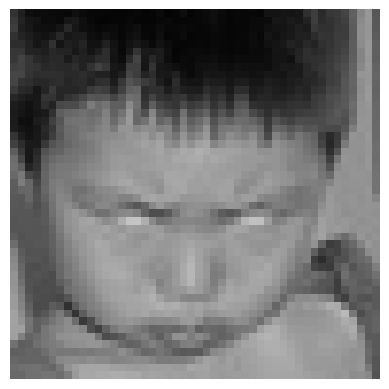

In [17]:
plt.axis('off')
plt.imshow(x_train[0])

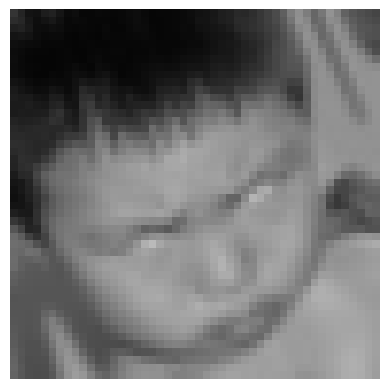

In [18]:
plt.axis('off') 
with tf.device('/CPU:0'):
    dat_ag = data_ag()
    plt.imshow(dat_ag(x_train)[0].numpy().astype("uint8"))


### now building CNN model:

In [20]:
num_classes = 7

In [23]:
def get_model():
    model = Sequential([
        data_ag(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])
    return model

we are using 3 layers of filters and with 'same' padding , to extract the feature map, then do the actual neural network layers to train the model

In [25]:
%%timeit -n1 -r1
with tf.device('/CPU:0'):
    cpu_model = get_model()
    cpu_model.fit(x_train_scaled, y_train, epochs=10, batch_size= 8)
    cpu_model.save('FER_cpu_model.keras')
    cpu_model.save_weights('./checkpoints/FER_cpu_model_checkpoint')

Epoch 1/10
3589/3589 [==============================] - 117s 32ms/step - loss: 1.7838 - accuracy: 0.2612
Epoch 2/10
3589/3589 [==============================] - 112s 31ms/step - loss: 1.6818 - accuracy: 0.3251
Epoch 3/10
3589/3589 [==============================] - 111s 31ms/step - loss: 1.5941 - accuracy: 0.3757
Epoch 4/10
3589/3589 [==============================] - 106s 30ms/step - loss: 1.5229 - accuracy: 0.4071
Epoch 5/10
3589/3589 [==============================] - 108s 30ms/step - loss: 1.4826 - accuracy: 0.4244
Epoch 6/10
3589/3589 [==============================] - 107s 30ms/step - loss: 1.4497 - accuracy: 0.4395
Epoch 7/10
3589/3589 [==============================] - 108s 30ms/step - loss: 1.4215 - accuracy: 0.4524
Epoch 8/10
3589/3589 [==============================] - 108s 30ms/step - loss: 1.4058 - accuracy: 0.4569
Epoch 9/10
3589/3589 [==============================] - 111s 31ms/step - loss: 1.3910 - accuracy: 0.4645
Epoch 10/10
3589/3589 [==============================] 

به علت این که گرافیک سیستم ضعیف بود امکان استفاده از گرافیک امکان پذیر نبود

با استفاده از پایپ لاین و بچ سایز هم مشکل گرافیک حل نشد

به همین علت مجبور به استفاده از سی پی یو شدم

In [26]:
with tf.device('/CPU:0'):
    new_model = tf.keras.models.load_model('FER_cpu_model.keras')
    new_model.evaluate(x_test_scaled,y_test)

225/225 [==============================] - 6s 25ms/step - loss: 1.3467 - accuracy: 0.4850


In [27]:
with tf.device('/CPU:0'):
    new_model = tf.keras.models.load_model('FER_cpu_model.keras')
    new_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 48, 48, 3)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 12, 12, 128)      

### confusion_matrix

In [28]:
from matplotlib import pyplot as plt
import seaborn as sn

In [29]:
with tf.device('/CPU:0'):
    new_model = tf.keras.models.load_model('FER_cpu_model.keras')
    y_predicted = new_model.predict(x_test_scaled)

225/225 [==============================] - 6s 24ms/step


Text(95.72222222222221, 0.5, 'Truth')

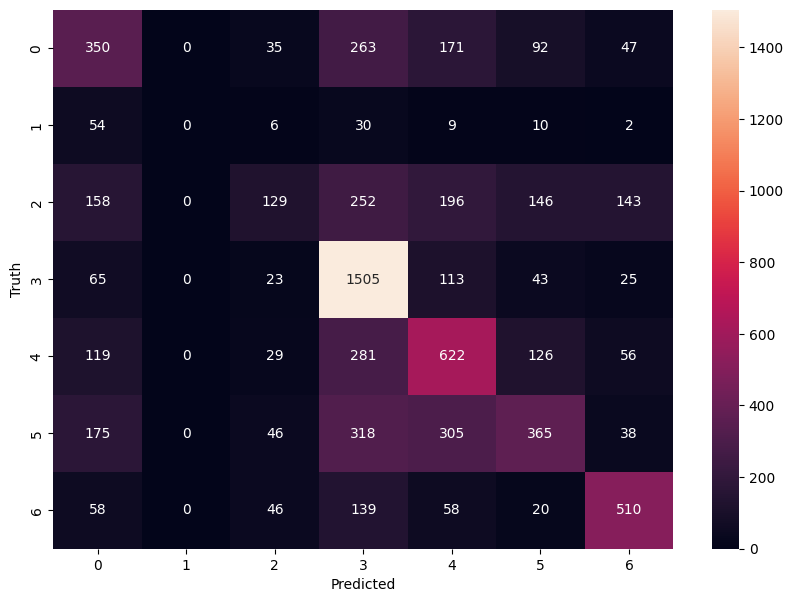

In [30]:
y_predicted_labels = [np.argmax(i) for i in y_predicted]
labels =['angry','disgust','fear','happy','neutral','sad','surprise']
y_labels = [labels[r] for r in y_predicted_labels]
y_test_label = [labels[t] for t in y_test]

cm = tf.math.confusion_matrix(labels=y_test,predictions=y_predicted_labels)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')